# Goal of this notebook
 
This notebook is used to analyse the distribution of Instagram profile and post data, preprocess it according to the findings of feature extraction, and train a Random Forest Regression model for the prediction of like counts for individual Instagram posts.

# 1) Exploratory Data Analysis

Initially, the training data from the dataset is loaded. The attributes extracted in the following section are mainly based on the feature extraction analysis run on profile data.

In [2]:
import pandas as pd

# Extract features from the training dataset
def extract_training_data(training_data):
    post_data = []
    profile_data = []

    for item in training_data:
        # Extract profile-level data
        profile = item.get('profile', {})
        profile_id = profile.get('id', 'UNKNOWN')
        username = profile.get('username', 'UNKNOWN')
        post_count = profile.get('post_count') 
        if post_count == None:  # this is checked because most post_count is missing in training dataset
            post_count = len(item.get('posts', []))
        follower_count = profile.get('follower_count', 0)
        highlight_reel_count = profile.get('highlight_reel_count', 0)

        # Save profile-level data
        profile_data.append({
            'profile_id': profile_id,
            'username': username,                
            'post_count': post_count,
            'follower_count': follower_count,
            'highlight_reel_count': highlight_reel_count,
        })
        
        # Extract post-level data
        for post in item.get('posts', []):
            post_id = post.get('id', 'UNKNOWN')
            caption = post.get('caption', '')
            like_count = post.get('like_count')
            comments_count = post.get('comments_count', 0)
            media_type = post.get('media_type', 'UNKNOWN')
            
            if like_count is not None:
                post_data.append({
                    'post_id': post_id,
                    'caption': caption,
                    'like_count': like_count,
                    'comments_count': comments_count,
                    'media_type': media_type,
                    'profile_id': profile_id
                })
    
    df_posts = pd.DataFrame(post_data)
    df_profiles = pd.DataFrame(profile_data).drop_duplicates(subset='profile_id')  
    df_combined = df_posts.merge(df_profiles, on='profile_id', how='left')
    
    # df_combined = df_combined.merge(category_labels, on='username', how='left')
    
    print(f"Extracted {len(df_combined)} rows of data after combining posts and profiles.")
    return df_combined

In [3]:
import json

# Load JSONL file
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    print(f"Loaded {len(data)} records from {file_path}.")
    return data

In [4]:
# Load the training data
training_data_path = 'training-dataset.jsonl'
training_data = load_jsonl(training_data_path)

# Extract the training data
df_combined  = extract_training_data(training_data)
df_combined.head()

Loaded 5415 records from training-dataset.jsonl.
Extracted 183083 rows of data after combining posts and profiles.


,post_id,caption,like_count,comments_count,media_type,profile_id,username,post_count,follower_count,highlight_reel_count
0,17990918969458720,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,6.0,0,IMAGE,3170700063,deparmedya,35.0,1167,6
1,18219250732221045,Oriflame Duologi Lansmanı #isveçtengelengüzell...,22.0,1,VIDEO,3170700063,deparmedya,35.0,1167,6
2,18311380465102328,#oriflameilesaçbakımdevrimi ✌️,19.0,0,VIDEO,3170700063,deparmedya,35.0,1167,6
3,18089518138361507,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,19.0,1,VIDEO,3170700063,deparmedya,35.0,1167,6
4,18012743929758497,07 Agustos’23 #oriflameturkiye #duoloji,21.0,0,VIDEO,3170700063,deparmedya,35.0,1167,6


The distributions of the extracted numerical attributions can be observed in the following plots.

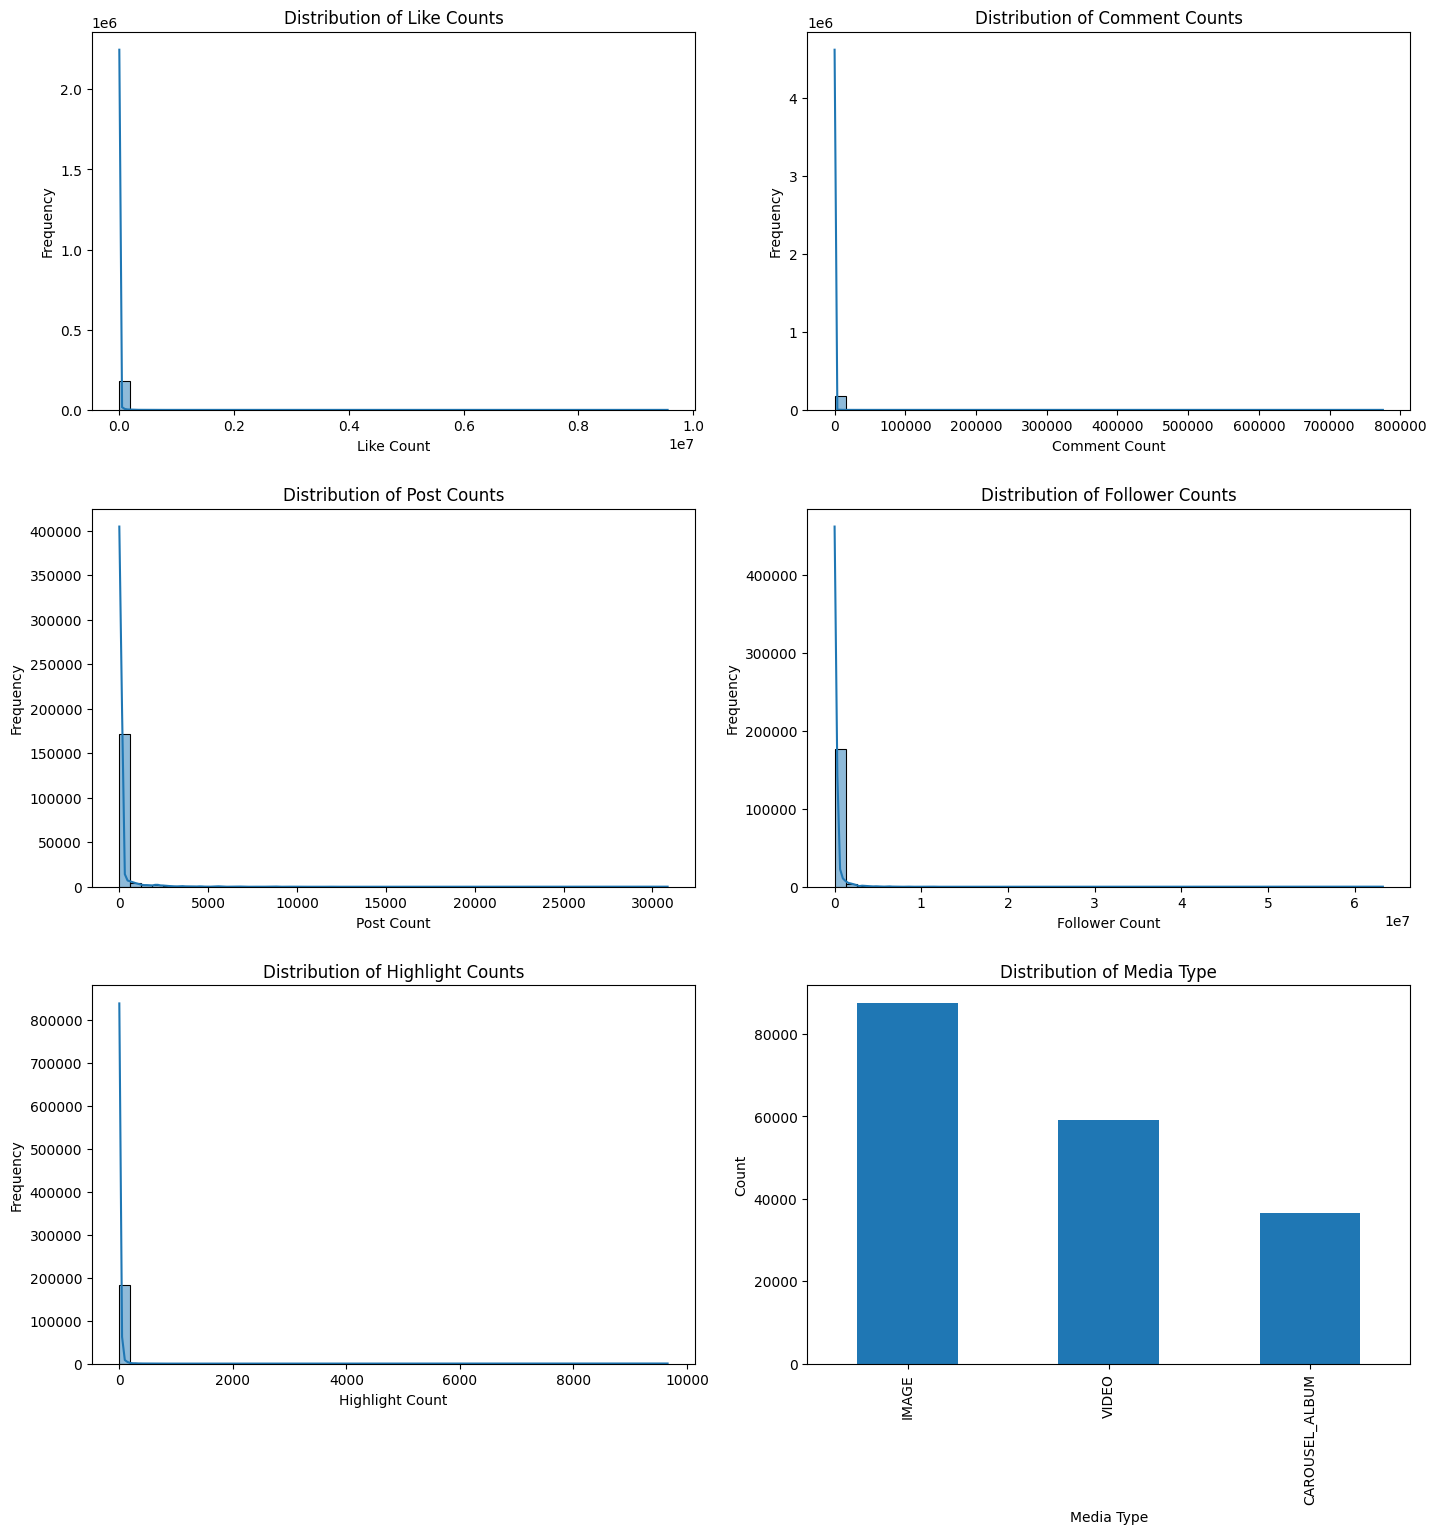

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grid layout with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  
plt.tight_layout(pad=5.0)

# Plot each distribution in the grid
sns.histplot(df_combined['like_count'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Like Counts')
axes[0, 0].set_xlabel('Like Count')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(df_combined['comments_count'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Comment Counts')
axes[0, 1].set_xlabel('Comment Count')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(df_combined['post_count'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Post Counts')
axes[1, 0].set_xlabel('Post Count')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(df_combined['follower_count'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Follower Counts')
axes[1, 1].set_xlabel('Follower Count')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(df_combined['highlight_reel_count'], bins=50, kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Highlight Counts')
axes[2, 0].set_xlabel('Highlight Count')
axes[2, 0].set_ylabel('Frequency')

# Plot media type distribution in the last subplot
media_type_distribution = df_combined['media_type'].value_counts()
media_type_distribution.plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_title('Distribution of Media Type')
axes[2, 1].set_xlabel('Media Type')
axes[2, 1].set_ylabel('Count')

# Show the plots
plt.show()


The obtained distribution plots show that all numerical attributes have a very uneven distribution. In order to reduce the effect of this unevenness, the data will be log-transformed in the data processing step.

# 2) Feature engineering

In addition to existing attributes, new relationships can be derived from the existing dataset. In order to utilise the dataset and uncover important relations that can help model training, feature engineering steps are conducted. In this respect, the following attributes are calculated: 
- followers per post
- comments to followers ratio 
- average like count for a user
- average comment count for a user
- hashtag count in a post caption

In [6]:
df_combined['followers_per_post'] = df_combined['follower_count'] / (df_combined['post_count'])  
df_combined['comments_to_followers_ratio'] = df_combined['comments_count'] / (df_combined['follower_count'] + 1)
df_combined['avg_like_for_user'] = df_combined.groupby('username')['like_count'].transform('mean')
df_combined['avg_comment_for_user'] = df_combined.groupby('username')['comments_count'].transform('mean')
df_combined['hashtag_count'] = df_combined['caption'].str.count('#')

df_combined.head()

,post_id,caption,like_count,comments_count,media_type,profile_id,username,post_count,follower_count,highlight_reel_count,followers_per_post,comments_to_followers_ratio,avg_like_for_user,avg_comment_for_user,hashtag_count
0,17990918969458720,Cumhuriyetimizin 100.yılı kutlu olsun♾️🇹🇷,6.0,0,IMAGE,3170700063,deparmedya,35.0,1167,6,33.342857,0.000000,11.542857,0.342857,0.0
1,18219250732221045,Oriflame Duologi Lansmanı #isveçtengelengüzell...,22.0,1,VIDEO,3170700063,deparmedya,35.0,1167,6,33.342857,0.000856,11.542857,0.342857,2.0
2,18311380465102328,#oriflameilesaçbakımdevrimi ✌️,19.0,0,VIDEO,3170700063,deparmedya,35.0,1167,6,33.342857,0.000000,11.542857,0.342857,1.0
3,18089518138361507,✌️#oriflameilesaçbakımdevrimi 07Agustos’23 ori...,19.0,1,VIDEO,3170700063,deparmedya,35.0,1167,6,33.342857,0.000856,11.542857,0.342857,1.0
4,18012743929758497,07 Agustos’23 #oriflameturkiye #duoloji,21.0,0,VIDEO,3170700063,deparmedya,35.0,1167,6,33.342857,0.000000,11.542857,0.342857,2.0


Similarly, the following plots show the distributions for the engineered features.

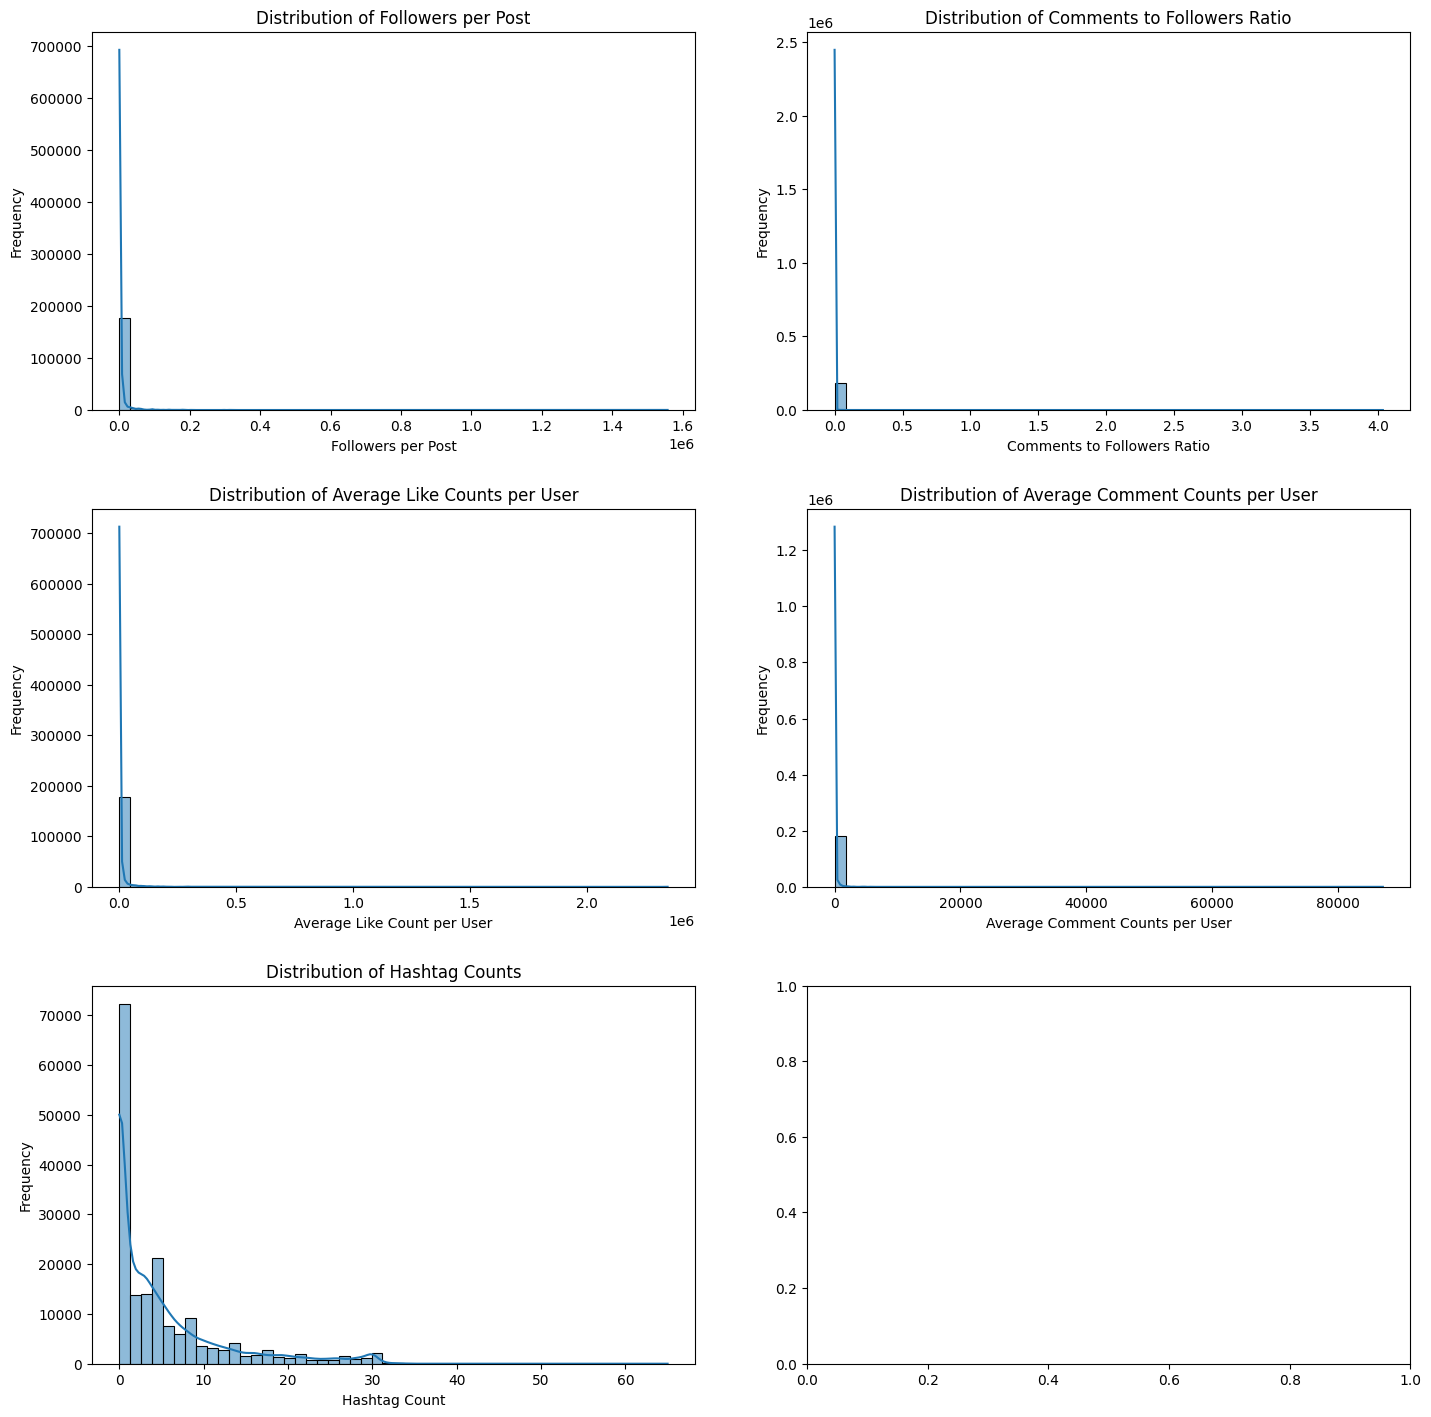

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a grid layout with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  
plt.tight_layout(pad=5.0)

# Plot each distribution in the grid
sns.histplot(df_combined['followers_per_post'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Followers per Post')
axes[0, 0].set_xlabel('Followers per Post')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(df_combined['comments_to_followers_ratio'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Comments to Followers Ratio')
axes[0, 1].set_xlabel('Comments to Followers Ratio')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(df_combined['avg_like_for_user'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Average Like Counts per User')
axes[1, 0].set_xlabel('Average Like Count per User')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(df_combined['avg_comment_for_user'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Average Comment Counts per User')
axes[1, 1].set_xlabel('Average Comment Counts per User')
axes[1, 1].set_ylabel('Frequency')

sns.histplot(df_combined['hashtag_count'], bins=50, kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Hashtag Counts')
axes[2, 0].set_xlabel('Hashtag Count')
axes[2, 0].set_ylabel('Frequency')

# Show the plots
plt.show()


The obtained distribution plots show that all engineered attributes have a very uneven distribution, similar to numerical attributes from the original dataset. In order to reduce the effect of this unevenness, the data will be log-transformed in the data processing step.

# 3) Data preprocessing

After the dataset is loaded with the attributes that will be used to train a model, the data is preprocessed in the following cells. The important aspects are as follows:
- Random Forests are robust to skewed data and outliers to some extent. However, preprocessing the numerical attributes will help with the model training nonetheless. Therefore, these numerical attributes are log-transformed in order to lower the effect of uneven distribution. 
- The caption data contains text-based information, therefore it needs to be preprocessed separately to utilise to the fullest. For this purpose, text preprocessing function is used. After that, TFIDF approach is used to represent the captions numerically, so that the Random Forest algorithm can make use of it. 
- Since media type is a categorical data type, it is encoded numerically, so that the Random Forest algorithm can make use of it as well.
- Missing values (if exists) are replaced with 0.
- After these steps, features from the data are combined with TFIDF features and standardised.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

def preprocess_text(text: str):
    # Lower casing Turkish Text, Don't use str.lower :)
    text = str(text)
    text = text.casefold()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Remove Turkish stopwords
def remove_stopwords(text):
    text = str(text)
    words = text.split()
    words = [word for word in words if word not in turkish_stopwords]
    return ' '.join(words)

def preprocess_combined_data(df):
    # Ensure no None or NaN values in the 'caption' column
    df['caption'] = df['caption'].fillna('').astype(str)

    # Handle heavy-tailed distributions with log transformation
    for field in ['comments_count', 'post_count', 'follower_count', 'highlight_reel_count',
                  'followers_per_post', 'comments_to_followers_ratio', 'avg_like_for_user', 'avg_comment_for_user', 'hashtag_count']:
        df[f'{field}_log'] = np.log1p(df.get(field, 0))

    # Preprocess the text in captions
    df['caption'] = df['caption'].apply(preprocess_text).apply(remove_stopwords)

    # Textual feature extraction using TF-IDF for captions
    vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_features = vectorizer.fit_transform(df['caption']).toarray()
    print(f"TF-IDF features shape: {tfidf_features.shape}")

    # Encode media type as a numerical feature
    media_type_mapping = {media: idx for idx, media in enumerate(df['media_type'].unique())}
    df['media_type_encoded'] = df['media_type'].map(media_type_mapping)

    # Replace infinite values and handle NaNs
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    # Combine features: TF-IDF, comments count, media type, profile-level features, and engineered features
    features = pd.DataFrame(tfidf_features)
    
    for feature in ['comments_count_log', 'media_type_encoded', 'post_count_log', 'follower_count_log', 'highlight_reel_count_log', 
                    'followers_per_post_log', 'comments_to_followers_ratio_log', 'avg_like_for_user_log', 'avg_comment_for_user_log', 'hashtag_count_log']:
        features[feature] = df[feature]

    # Ensure all column names are strings
    features.columns = features.columns.astype(str)
    print("Feature columns:", features.columns)
    
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    print("Features standardized.")
    
    # Return processed features and target variable
    return features_scaled, np.log1p(df['like_count']), vectorizer, scaler, features.columns, media_type_mapping


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilayd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
X, y, tfidf_vectorizer, feature_scaler, feature_columns, media_type_mapping = preprocess_combined_data(df_combined)

# Save vectorizer and scaler for later use
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Preprocessing complete. Ready for model training!")

TF-IDF features shape: (183083, 1000)
Feature columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'comments_count_log', 'media_type_encoded', 'post_count_log',
       'follower_count_log', 'highlight_reel_count_log',
       'followers_per_post_log', 'comments_to_followers_ratio_log',
       'avg_like_for_user_log', 'avg_comment_for_user_log',
       'hashtag_count_log'],
      dtype='object', length=1010)
Features standardized.
Preprocessing complete. Ready for model training!


# 4) Random Forest Regression

After the data is prepared and preprocessed, the model can finally be trained. For this purpose, the dataset is splitted into training and test with 80:20 ratio. Then, the Random Forest Regression model is trained on the training dataset with the following parameters, which were determined after experimentation:
- n_estimators: The number of trees in the forest is 100.
- max_depth: The maximum depth of the tree is 10.
- min_samples_split: The minimum number of samples required to split an internal node is 5.
- min_samples_leaf: The minimum number of samples required to be at a leaf node is 4.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, min_samples_split=5, min_samples_leaf=4)
rf_regressor.fit(X_train, y_train)

# Use the trained model for prediction of like counts
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

Training set shape: (146466, 1010), Test set shape: (36617, 1010)


After the model is trained and the predictions are completed, the model is evaluated using RMSE (root mean squared error) and R^2 (R-squared). Accordingly, the better-performing model was determined based on the presence of a low RMSE with a high R^2 value.

**RMSE:** RMSE quantifies how well the Random Forest model is predicting continuous target values. A lower RMSE indicates a better fit to the data.

**R^2:** R² indicates how well the regression model explains the variance in the target. It ranges between 0 and 1, 1 indicating a perfect fit. Higher R^2 values indicate a better model.



**Additional note:** Since the data and the target have been log-transformed during preprocessing, they need to be exponentiated back to the original scale before evaluation metrices are calculated.

In [16]:
# Predict in the log-transformed space
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Reverse log transformation for predictions and actual values
y_train_pred_actual = np.expm1(y_train_pred)
y_test_pred_actual = np.expm1(y_test_pred)
y_train_actual = np.expm1(y_train) 
y_test_actual = np.expm1(y_test)

# Calculate RMSE in the original scale
train_rmse_original = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
test_rmse_original = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))

# Calculate R² scores in the original scale
train_r2_original = r2_score(y_train_actual, y_train_pred_actual)
test_r2_original = r2_score(y_test_actual, y_test_pred_actual)

# Print evaluation results
print(f"Training RMSE (Original Scale): {train_rmse_original}")
print(f"Testing RMSE (Original Scale): {test_rmse_original}")
print(f"Training R² (Original Scale): {train_r2_original}")
print(f"Testing R² (Original Scale): {test_r2_original}")

Training RMSE (Original Scale): 30086.189995382483
Testing RMSE (Original Scale): 20604.289017419476
Training R² (Original Scale): 0.800069984478089
Testing R² (Original Scale): 0.8044876477345928


In [12]:
# Save the trained model
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_regressor, f)
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("Model training complete and saved!")

Model training complete and saved!
